In [13]:
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import jaxgp.regression as gpr
from jaxgp.kernels import RBF, Linear

import testfunctions
from jaxgp.utils import Logger

In [14]:
def function(x):
    return jnp.sin(2*x[0] + x[1])

In [15]:
def make_unique(X, Y):
    index1 = jnp.unique(X[:,0],return_index=True)[1]
    temp = X[index1]
    index2 = jnp.unique(temp[:,1], return_index=True)[1]
    return X[index2], Y[index2]

In [16]:
optimizers = ["Nelder-Mead", "L-BFGS-B", "TNC", "SLSQP", "Powell", "trust-constr"]

seed = 0
num_gridpoints = jnp.array([100,100])
num_datapoints = jnp.prod(num_gridpoints)
noise = 0.0
ranges = (jnp.array([0,2*jnp.pi]),jnp.array([0,2*jnp.pi]))
# fun = testfunctions.franke
fun = function

X_train, Y_train = testfunctions.create_training_data_2D(seed, num_gridpoints, ranges, noise, fun)
# X_train, Y_train = make_unique(X_train, Y_train)

iters_per_optimizer = 1

# function_set_sizes = [1, 5, 10, 50, 100]
function_set_sizes = [10,]
# derivative_set_sizes = [10, 50, 100, 500, 1000, 2000, 5000]
derivative_set_sizes = [100,]

kernel = RBF()
param_shape = (2,)
param_bounds = (1e-3, 10.0)

grids = jnp.linspace(0,1,100)
grid = jnp.array(jnp.meshgrid(grids, grids)).reshape(2,-1).T

In [20]:
key = random.PRNGKey(-101)

means = []
stds = []

for fun_vals in function_set_sizes:
    for der_vals in derivative_set_sizes:
        # logger for each pair of function vals and derivative vals
        logger = Logger(f"f{fun_vals}d{der_vals}")

        key, subkey = random.split(key)
        fun_perm = random.permutation(subkey, num_datapoints)[:fun_vals]
        key, subkey = random.split(key)
        d1_perm = random.permutation(subkey, num_datapoints)[:der_vals]
        key, subkey = random.split(key)
        d2_perm = random.permutation(subkey, num_datapoints)[:der_vals]

        X_fun = X_train[fun_perm]
        Y_fun = Y_train[fun_perm,0]
        X_d1 = X_train[d1_perm]
        Y_d1 = Y_train[d1_perm,1]
        X_d2 = X_train[d2_perm]
        Y_d2 = Y_train[d2_perm,2]

        X = jnp.vstack((X_fun, X_d1, X_d2))
        Y = jnp.hstack((Y_fun, Y_d1, Y_d2))
        data_split = jnp.array([function_set_sizes, derivative_set_sizes, derivative_set_sizes])

        for i in range(iters_per_optimizer):
            key, subkey = random.split(key)
            init_params = random.uniform(subkey, param_shape, minval=param_bounds[0], maxval=param_bounds[1])
            init_params = jnp.array([1.0, 1.0])

            model = gpr.ExactGPR(kernel, init_params, noise)
            model.train(X, Y, data_split=data_split)
            m, s = model.eval(grid)
            means.append(m)
            stds.append(s)

OptStep(params=DeviceArray([1., 1.], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(nan, dtype=float32, weak_type=True), success=False, status=2, iter_num=0))


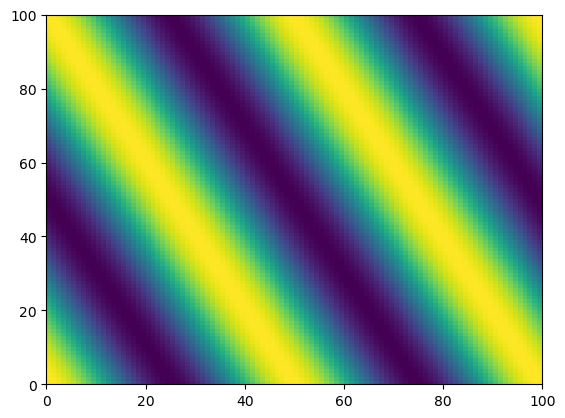

In [18]:
plt.pcolormesh(Y_train[:,2].reshape(100,100))

In [19]:
mean = means[0].reshape(100,100)
std = stds[0].reshape(100,100)

plt.pcolormesh(grids, grids, mean)

print(means)

IndexError: list index out of range

### tangent plotting helper

In [ ]:
def plot_tangent(ax,x0, y0, dy0):
    x = jnp.linspace(x0-0.1, x0+0.1,2)
    tangent = dy0*(x - x0) + y0

    ax.plot(x, tangent,ls="--", color="red")